### Perecentile clip and normalization for EVCs batch

In [ ]:
from utils import percentile_clip, create_mask, normalize
import rasterio
import os
import numpy as np

evc_dir = ''
output_dir = ''

os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(evc_dir):
    try:
        if file.endswith(".tif"):
            
            evc_path = os.path.join(evc_dir, file)
            output_path = os.path.join(output_dir, file)

            # Open the CRISM .tif file with rasterio
            with rasterio.open(evc_path) as crism_ds:
                # Read the data into a NumPy array
                np_crism = crism_ds.read()

                mask = create_mask(np_crism)

                np_crism_masked = np.where(mask, np_crism, np.nan)

                # Apply percentile clipping and pair normalization
                clipped_data = percentile_clip(np_crism_masked)
                normalized_clipped_data = normalize(clipped_data)

                # Prepare metadata for the output file
                meta = crism_ds.meta.copy()
                meta.update({
                    'dtype': normalized_clipped_data.dtype.name,
                    'driver': 'GTiff',
                    'nodata': 65535
                })

                # Save the clipped data as a new .img file
                with rasterio.open(output_path, "w", **meta) as dst:
                    dst.write(normalized_clipped_data)

            
            print(f"Finished: {file}")

    except Exception as e:
        print(f"Error processing {file}: {e}")

Finished: FRT00005C5E_07_IFEVCJ_MTR3.tif


### ISIS cubes files normalization batch

In [ ]:
from utils import percentile_clip, normalize, create_masked_data
import rasterio
import os
import numpy as np

ctx_dir = ''
output_dir = ''


os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(ctx_dir):
    try:
        if file.endswith(".cub"):
            
            ctx_path = os.path.join(ctx_dir, file)
            output_path = os.path.join(output_dir, file)

            # Open the CRISM .img file with rasterio
            with rasterio.open(ctx_path, driver="ISIS3") as ctx_ds:
                # Read the data into a NumPy array
                np_ctx = ctx_ds.read()

                masked = create_masked_data(np_ctx, -3.4028227e+38)

                # Apply percentile clipping and pair normalization
                clipped_data = percentile_clip(masked)
                normalized_clipped_data = normalize(clipped_data)

                # Prepare metadata for the output file
                meta = ctx_ds.meta.copy()
                meta.update({
                    'driver': 'ISIS3',
                    'nodata': -3.4028227e+38,
                    'dtype': normalized_clipped_data.dtype.name,
                })

                # Save the clipped data as a new .img file
                with rasterio.open(output_path, "w", **meta) as dst:
                    dst.write(normalized_clipped_data)

            
            print(f"Finished: {file}")

    except Exception as e:
        print(f"Error processing {file}: {e}")

Finished: FRT00005C5E_07_IFEVCJ_MTR3_MY36_020142_020_3.cub


### Single pair normalization

In [ ]:
from utils import normalize, create_masked_data, percentile_clip
import rasterio

cassis_path = ""
cassis_out_path = ""
crism_path = ""
crism_out_path = ""

with rasterio.open(cassis_path) as cassis_ds, rasterio.open(crism_path) as crism_ds:
    cassis_data = cassis_ds.read()
    crism_data = crism_ds.read()

    cassis_masked = create_masked_data(cassis_data, cassis_ds.nodata)
    crism_masked = create_masked_data(crism_data, crism_ds.nodata)

    cassis_normalized = normalize(percentile_clip(cassis_masked))
    crism_normalized = normalize(percentile_clip(crism_masked))
    
    cassis_meta = cassis_ds.meta.copy()
    cassis_meta.update({
        'dtype': cassis_normalized.dtype.name,
    })
    
    crism_meta = crism_ds.meta.copy()
    crism_meta.update({
        'dtype': crism_normalized.dtype.name,
    })    

    # Save the clipped data as a new .img file
    with rasterio.open(cassis_out_path, "w", **cassis_meta) as dst:
        dst.write(cassis_normalized)

    with rasterio.open(crism_out_path, "w", **crism_meta) as dst:
        dst.write(crism_normalized)


### Display image

d:\USER\Studies_in_THD\thesis\hyperspectral_mars\utils.py:292: RuntimeWarning: invalid value encountered in cast
  return band_norm.astype(np.uint8)


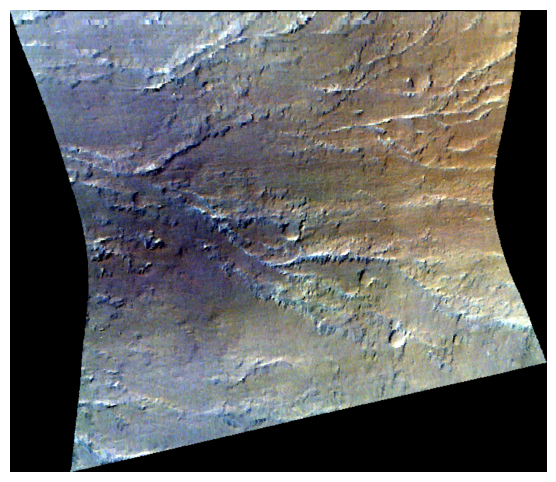

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from utils import create_mask, create_np_image

crism_path = ''

with rasterio.open(crism_path) as crism_ds:
    crism_data = crism_ds.read()
    mask = create_mask(crism_data)

    image = create_np_image(crism_data, mask, True)

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Value distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

def visualize_all_channel_distributions(file_path, bins=100, wavelengths=None):
    """
    Visualize the value distribution of all channels in an image.

    Args:
        file_path (str): Path to the ENVI .img file.
        bins (int): Number of bins for the histograms.
    """
    # Open the .img file with rasterio
    with rasterio.open(file_path) as ds:
        num_channels = ds.count
        masked_ds = ds.read()
        colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']  # Add more if needed
        labels = wavelengths if wavelengths else [f"Channel {i + 1}" for i in range(num_channels)]
        
        plt.figure(figsize=(8, 6))
        
        for i in range(num_channels):
            channel_data = masked_ds[i].flatten()  # Flatten data for histogram
            hist, bin_edges = np.histogram(channel_data[~np.isnan(channel_data)], bins=bins, density=True)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            
            plt.plot(bin_centers, hist, color=colors[i % len(colors)], label=labels[i], linewidth=2)

        plt.title("Histogram", fontsize=14)
        plt.xlabel("Pixel Value", fontsize=12)
        plt.ylabel("Relative Frequency", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

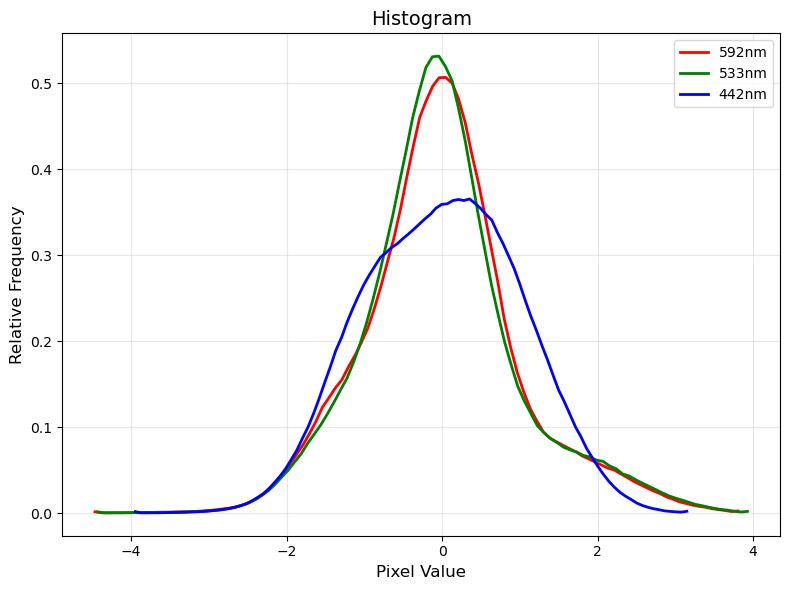

In [ ]:

wavelengths = ["592nm", "533nm", "442nm"]
file_path = ''  # Path to CRISM .img file
visualize_all_channel_distributions(file_path, bins=100, wavelengths=wavelengths)

### Display all normalized value distribution

Processing: MY35_009664_162_0.cubeit.cub


C:\Users\USER\AppData\Local\Temp\ipykernel_1764\2797046458.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_channels).colors  # Get distinct colors


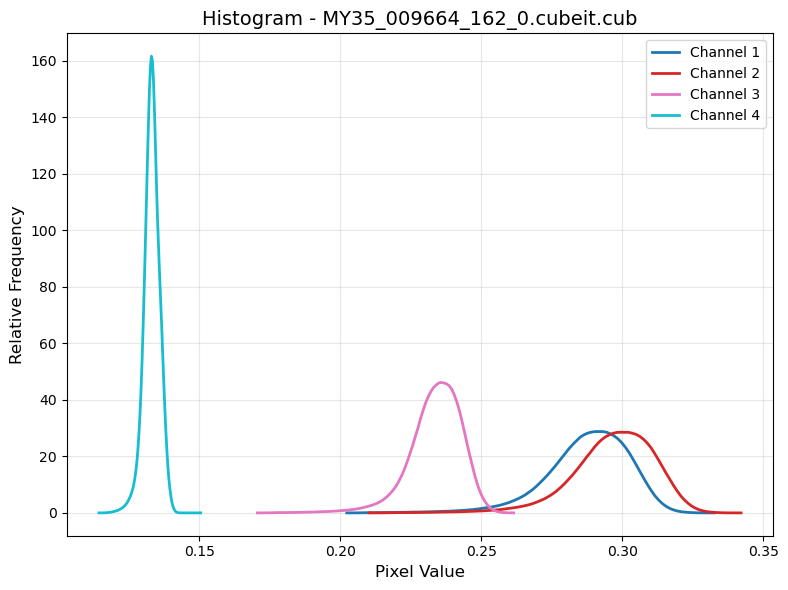

Processing: MY36_016378_162_2.cubeit.cub


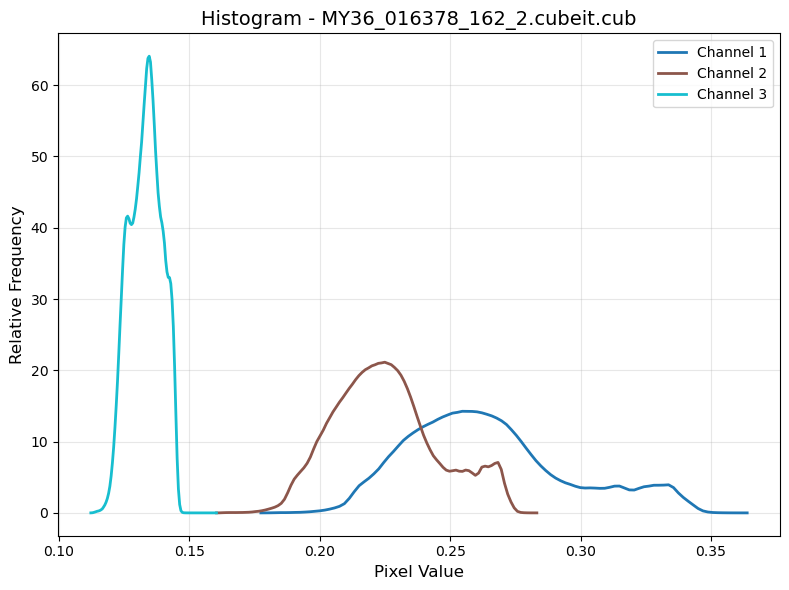

Processing: MY36_016465_161_0.cubeit.cub


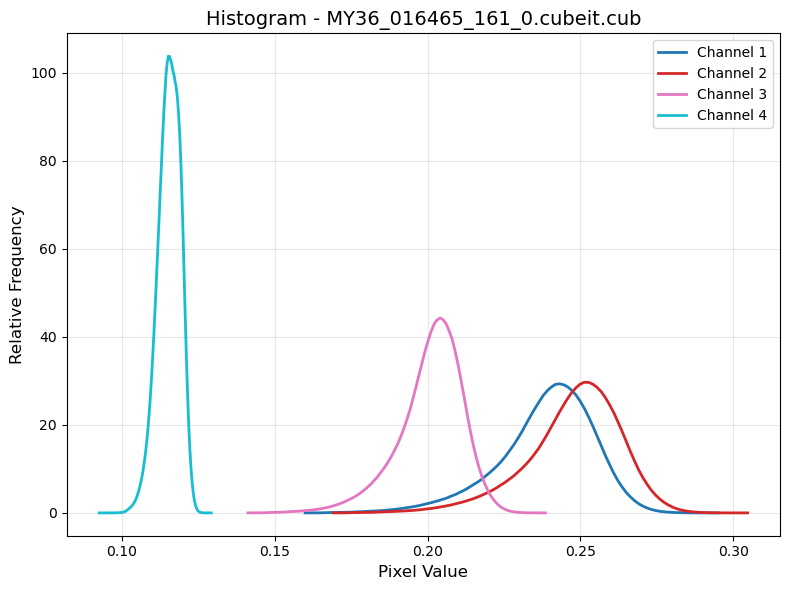

Processing: MY36_017709_165_0.cubeit.cub


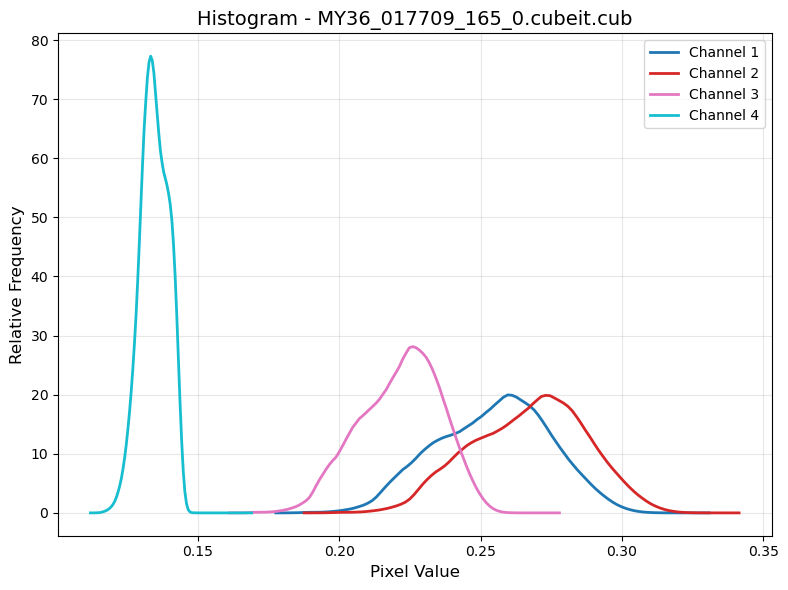

Processing: MY36_020142_020_3.cubeit.cub


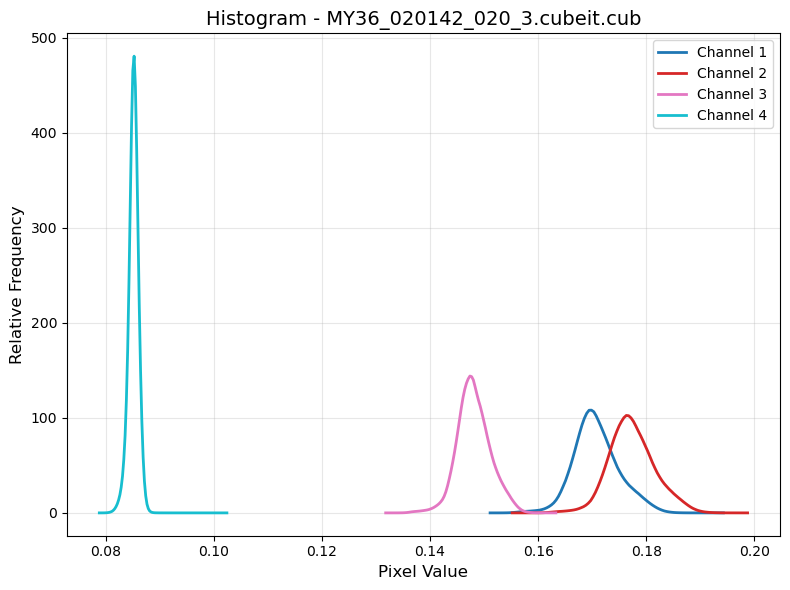

Processing: MY36_020471_161_1.cubeit.cub


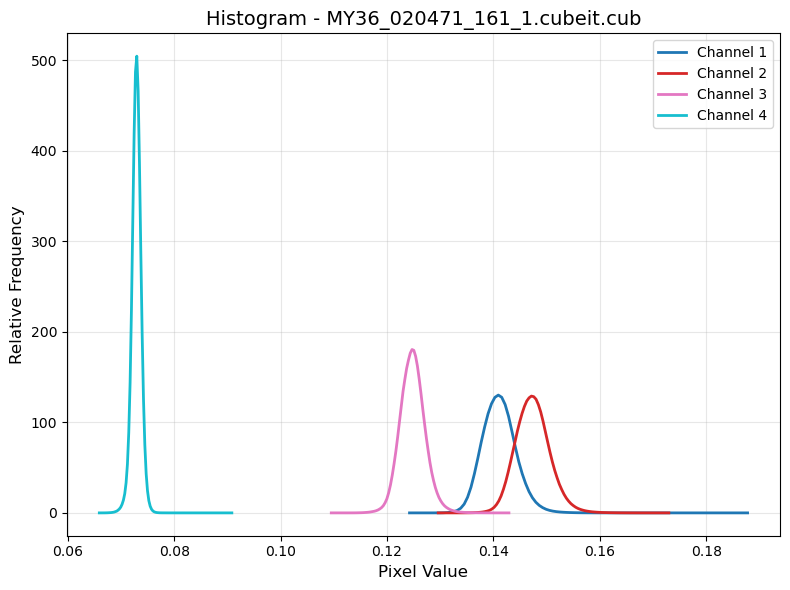

Processing: MY37_024061_018_0.cubeit.cub


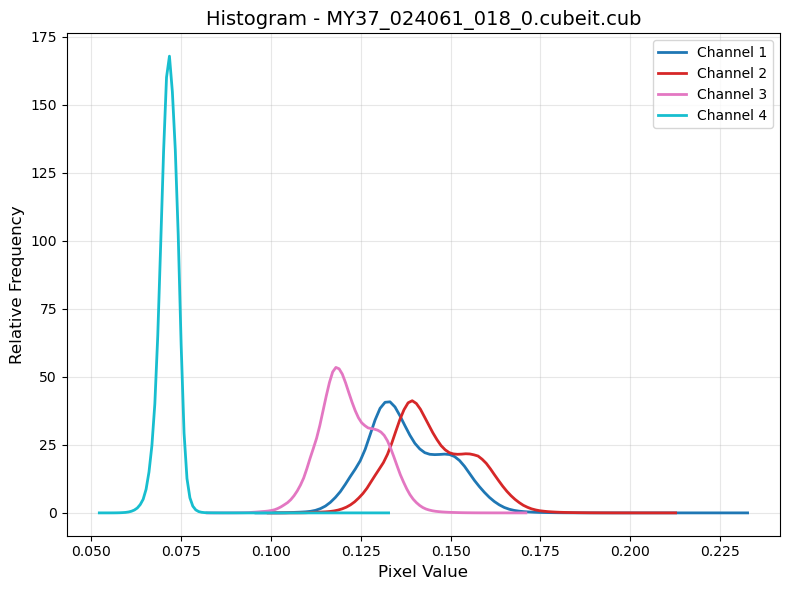

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from utils import create_masked_data

def list_img_files(directory, ext):
    """Lists all .img files in a directory."""
    return [f for f in os.listdir(directory) if f.endswith(ext)]

def visualize_all_channel_distributions(file_path, bins=100, wavelengths=None):
    """
    Visualize the value distribution of all channels in an image.

    Args:
        file_path (str): Path to the ENVI .img file.
        bins (int): Number of bins for the histograms.
        wavelengths (list, optional): List of wavelength labels corresponding to the bands.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    with rasterio.open(file_path) as ds:
        num_channels = ds.count
        masked_ds = create_masked_data(ds.read())

        # Generate dynamic colors for visualization
        colors = plt.cm.get_cmap('tab10', num_channels).colors  # Get distinct colors
        labels = wavelengths if wavelengths else [f"Channel {i + 1}" for i in range(num_channels)]
        
        plt.figure(figsize=(8, 6))
        
        for i in range(num_channels):
            channel_data = masked_ds[i].flatten()  # Flatten for histogram
            valid_data = channel_data[~np.isnan(channel_data)]  # Remove NaNs

            if valid_data.size > 0:
                hist, bin_edges = np.histogram(valid_data, bins=bins, density=True)
                bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                plt.plot(bin_centers, hist, color=colors[i % len(colors)], label=labels[i], linewidth=2)

        plt.title(f"Histogram - {os.path.basename(file_path)}", fontsize=14)
        plt.xlabel("Pixel Value", fontsize=12)
        plt.ylabel("Relative Frequency", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()



directory = "./holden/crism"  # Adjust directory path
ext = ".img"
img_files = list_img_files(directory, ext)

if not img_files:
    print("No .img files found in the directory.")
else:
    for file in img_files:
        print(f"Processing: {file}")
        visualize_all_channel_distributions(os.path.join(directory, file))
